In [1]:
import pandas as pd
import numpy as np
import os

In [21]:
# load a csv called data.csv with the separation character ','

geo_data = pd.read_csv('raw_data/geo_eth.csv', sep=',')
cons_data = pd.read_csv('raw_data/cons_eth.csv', sep=',')

In [22]:
geo_data.head()

,household_id2,ea_id2,dist_road,dist_popcenter,dist_market,dist_borderpost,dist_admctr,pop_density,af_bio_1,af_bio_8,...,eviarea_avg,evimax_avg,grn_avg,sen_avg,h2015_eviarea,h2015_evimax,h2015_grn,h2015_sen,lat_dd_mod,lon_dd_mod
0,10101088801601002,10101088801601,50,53,105,134,198,0-50,264,258,...,46,0.432,177,257,40,0.386,173,256,14.353816,37.890876
1,10101088801601017,10101088801601,50,53,106,135,198,0-50,263,257,...,46,0.432,177,257,40,0.386,173,256,14.353816,37.890876
2,10101088801601034,10101088801601,46,49,100,135,195,0-50,262,256,...,46,0.432,177,257,40,0.386,173,256,14.353816,37.890876
3,10101088801601049,10101088801601,46,49,100,135,195,0-50,262,256,...,46,0.432,177,257,40,0.386,173,256,14.353816,37.890876
4,10101088801601064,10101088801601,46,49,100,135,195,0-50,262,256,...,46,0.432,177,257,40,0.386,173,256,14.353816,37.890876


In [23]:
cons_data.head()

,household_id,household_id2,ea_id,ea_id2,saq01,rural,pw_w3,adulteq,hh_size,no_conv,no_cons,food_cons_ann,nonfood_cons_ann,educ_cons_ann,total_cons_ann,price_index_hce,nom_totcons_aeq,cons_quint
0,1010101601002,10101088801601002,1010101601,10101088801601,1,1,2897.155029,0.74,1,0,0,1970.800049,1013.0,0.0,2983.800049,1.034,4032.162109,2.0
1,1010101601017,10101088801601017,1010101601,10101088801601,1,1,2897.155029,7.21,9,0,0,7883.200195,5337.0,358.0,13578.200195,1.034,1883.245483,1.0
2,1010101601034,10101088801601034,1010101601,10101088801601,1,1,2897.155029,0.74,1,0,0,8958.444458,322.0,0.0,9280.444336,1.034,12541.140625,5.0
3,1010101601049,10101088801601049,1010101601,10101088801601,1,1,2897.155029,2.50,3,0,0,9594.000000,1630.0,480.0,11704.000000,1.034,4681.600098,3.0
4,1010101601064,10101088801601064,1010101601,10101088801601,1,1,2897.155029,1.58,2,0,0,11702.888916,3272.0,0.0,14974.888672,1.034,9477.778320,5.0


In [24]:

COUNTRIES_DIR = os.path.join("..", 'data', 'countries')

In [25]:
def process_ethiopia():

    consumption_pc_col = 'total_cons_ann' # per capita
    hhsize_col = 'hh_size' # people in household

    lat_col = 'lat_dd_mod'
    lon_col = 'lon_dd_mod'

    # purchasing power parity for ethiopia in 2015 (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP?locations=ET)
    ppp = 7.882
    
    # for file in [consumption_file, geovariables_file]:
    #     assert os.path.isfile(os.path.join(lsms_dir, file)), print(f'Could not find {file}')
    
    df = cons_data
    df['cons_ph'] = df[consumption_pc_col] * df[hhsize_col]
    df['pph'] = df[hhsize_col]
    df['cons_ph'] = df['cons_ph'] / ppp / 365
    df = df[['household_id2', 'cons_ph', 'pph']]

    df_geo = geo_data
    df_cords = df_geo[['household_id2', lat_col, lon_col]]
    df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)
    df_combined = pd.merge(df, df_cords, on='household_id2')
    df_combined.drop(['household_id2'], axis=1, inplace=True)
    df_combined.dropna(inplace=True) # can't use na values
    
    df_clusters = df_combined.groupby(['cluster_lat', 'cluster_lon']).sum().reset_index()
    df_clusters['cons_pc'] = df_clusters['cons_ph'] / df_clusters['pph'] # divides total cluster income by people
    df_clusters['country'] = 'eth'
    return df_clusters[['country', 'cluster_lat', 'cluster_lon', 'cons_pc']]

In [26]:
data = process_ethiopia()

/tmp/ipykernel_452607/1253664893.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)


In [27]:
data.head(3)

,country,cluster_lat,cluster_lon,cons_pc
0,eth,3.455701,39.515994,14.854634
1,eth,3.549937,39.184234,14.312022
2,eth,3.864243,39.101366,12.470145


In [45]:
filtered_df = data[
    (data['cluster_lat'] >= 8.9) & (data['cluster_lat'] <= 9.1) &
    (data['cluster_lon'] >= 38.7) & (data['cluster_lon'] <= 38.9)
]

In [46]:
filtered_df

,country,cluster_lat,cluster_lon,cons_pc
210,eth,8.954261,38.776901,30.038594
211,eth,8.957485,38.762128,10.622940
212,eth,8.958031,38.748086,12.825229
213,eth,8.964058,38.721902,20.488550
216,eth,8.989751,38.773653,17.768381
219,eth,9.013835,38.741334,14.816839
220,eth,9.015257,38.813750,20.499866
222,eth,9.018709,38.789997,12.782309
223,eth,9.020116,38.733379,18.206968
224,eth,9.023574,38.784249,11.709447


In [47]:
import math
def create_space(lat, lon, s=1):
    """Creates a s km x s km square centered on (lat, lon)"""
    v = (180/math.pi)*(500/6378137)*s # roughly 0.045 for s=10
    return lat - v, lon - v, lat + v, lon + v

In [49]:
import rasterio

url_image = "raw_data/picture.tif"
with rasterio.open(url_image) as src:
    image_data = src.read(1)  
    transform = src.transform
    tif_array = np.squeeze(image_data)

    print(tif_array.shape)

(18000, 28800)


In [50]:
def custom_rasterio_open( min_lon, min_lat):
    xminPixel, ymaxPixel = ~transform * (min_lon, min_lat)
        
    xminPixel, ymaxPixel = int(xminPixel), int(ymaxPixel)
    
    return xminPixel, ymaxPixel

In [52]:
def add_nightlights(df, tif_array):
    ''' 
    This takes a dataframe with columns cluster_lat, cluster_lon and finds the average 
    nightlights in 2015 using a 10kmx10km box around the point
    
    I try all the nighlights tifs until a match is found, or none are left upon which an error is raised
    '''
    cluster_nightlights = []
    for i,r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        
        xminPixel, ymaxPixel = custom_rasterio_open(min_lon, min_lat)
        xmaxPixel, yminPixel = custom_rasterio_open(max_lon, max_lat)
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        cluster_nightlights.append(tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())
        
    df['nightlights'] = cluster_nightlights

In [53]:
add_nightlights(filtered_df, tif_array)

/tmp/ipykernel_452607/1028853878.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nightlights'] = cluster_nightlights


In [54]:
filtered_df

,country,cluster_lat,cluster_lon,cons_pc,nightlights
210,eth,8.954261,38.776901,30.038594,12.982849
211,eth,8.957485,38.762128,10.622940,13.574224
212,eth,8.958031,38.748086,12.825229,10.491421
213,eth,8.964058,38.721902,20.488550,13.143794
216,eth,8.989751,38.773653,17.768381,28.734900
219,eth,9.013835,38.741334,14.816839,24.621498
220,eth,9.015257,38.813750,20.499866,17.520323
222,eth,9.018709,38.789997,12.782309,14.007886
223,eth,9.020116,38.733379,18.206968,18.812723
224,eth,9.023574,38.784249,11.709447,13.091982


/tmp/ipykernel_452607/3075944088.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cons_pc'] = scaler.fit_transform(filtered_df['cons_pc'].values.reshape(-1,1))
/tmp/ipykernel_452607/3075944088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['nightlights'] = scaler.fit_transform(filtered_df['nightlights'].values.reshape(-1,1))


<AxesSubplot:xlabel='cons_pc', ylabel='nightlights'>

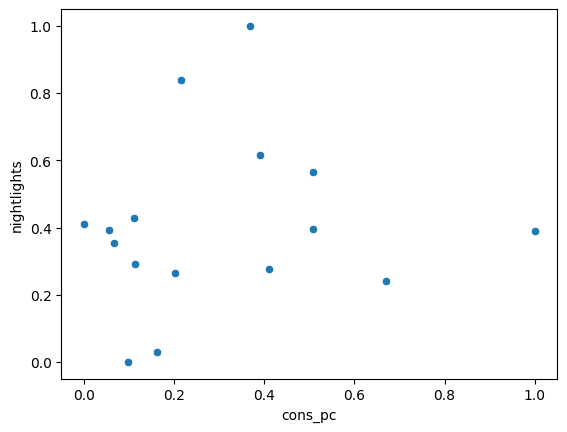

In [55]:
# import seaborn as sns
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# filtered_df['cons_pc'] = scaler.fit_transform(filtered_df['cons_pc'].values.reshape(-1,1))
# filtered_df['nightlights'] = scaler.fit_transform(filtered_df['nightlights'].values.reshape(-1,1))

# sns.scatterplot(x='cons_pc', y='nightlights', data=filtered_df)


In [56]:
# select only one column of filtered_df

# filtered_df = filtered_df[0:1]
filtered_df

,country,cluster_lat,cluster_lon,cons_pc,nightlights
210,eth,8.954261,38.776901,1.000000,0.388265
211,eth,8.957485,38.762128,0.000000,0.411232
212,eth,8.958031,38.748086,0.113429,0.291510
213,eth,8.964058,38.721902,0.508127,0.394516
216,eth,8.989751,38.773653,0.368025,1.000000
219,eth,9.013835,38.741334,0.216006,0.840255
220,eth,9.015257,38.813750,0.508709,0.564479
222,eth,9.018709,38.789997,0.111218,0.428073
223,eth,9.020116,38.733379,0.390614,0.614670
224,eth,9.023574,38.784249,0.055960,0.392504


In [57]:
import random
RANDOM_SEED = 7

def generate_download_locations(df, ipc=50):
    '''
    Takes a dataframe with columns cluster_lat, cluster_lon
    Generates a 10km x 10km bounding box around the cluster and samples 
    ipc images per cluster. First samples in a grid fashion, then any 
    remaining points are randomly (uniformly) chosen
    '''
    np.random.seed(RANDOM_SEED) # for reproducability
    df_download = {'image_name': [], 'image_lat': [], 'image_lon': [], 'cluster_lat': [], 
                   'cluster_lon': [], 'cons_pc': [], 'nightlights': [] }
    
    # side length of square for uniform distribution
    edge_num = math.floor(math.sqrt(ipc))
    for _, r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        lats = np.linspace(min_lat, max_lat, edge_num).tolist()
        lons = np.linspace(min_lon, max_lon, edge_num).tolist()

        # performs cartesian product
        uniform_points = np.transpose([np.tile(lats, len(lons)), np.repeat(lons, len(lats))])
        
        lats = uniform_points[:,0].tolist()
        lons = uniform_points[:,1].tolist()
        
        # fills the remainder with random points
        for _ in range(ipc - edge_num * edge_num):
            lat = random.uniform(min_lat, max_lat)
            lon = random.uniform(min_lon, max_lon)
            lats.append(lat)
            lons.append(lon)
        
        # add to dict
        for lat, lon in zip(lats, lons):
            # image name is going to be image_lat_image_lon_cluster_lat_cluster_lon.png
            image_name = str(lat) + '_' + str(lon) + '_' + str(r.cluster_lat) + '_' + str(r.cluster_lon) + '.png'
            df_download['image_name'].append(image_name)
            df_download['image_lat'].append(lat)
            df_download['image_lon'].append(lon)
            df_download['cluster_lat'].append(r.cluster_lat)
            df_download['cluster_lon'].append(r.cluster_lon)
            df_download['cons_pc'].append(r.cons_pc)
            df_download['nightlights'].append(r.nightlights)
        
    return pd.DataFrame.from_dict(df_download)

In [58]:
df_eth_download = generate_download_locations(filtered_df)

In [59]:
df_eth_download

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,nightlights
0,8.949769436589403_38.7724098381794_8.954261013...,8.949769,38.772410,8.954261,38.776901,1.000000,0.388265
1,8.951266628729602_38.7724098381794_8.954261013...,8.951267,38.772410,8.954261,38.776901,1.000000,0.388265
2,8.952763820869801_38.7724098381794_8.954261013...,8.952764,38.772410,8.954261,38.776901,1.000000,0.388265
3,8.95426101301_38.7724098381794_8.95426101301_3...,8.954261,38.772410,8.954261,38.776901,1.000000,0.388265
4,8.9557582051502_38.7724098381794_8.95426101301...,8.955758,38.772410,8.954261,38.776901,1.000000,0.388265
...,...,...,...,...,...,...,...
795,9.07181262124_38.7344206223206_9.07181262124_3...,9.071813,38.734421,9.071813,38.729929,0.163242,0.030536
796,9.073309813380199_38.7344206223206_9.071812621...,9.073310,38.734421,9.071813,38.729929,0.163242,0.030536
797,9.074807005520398_38.7344206223206_9.071812621...,9.074807,38.734421,9.071813,38.729929,0.163242,0.030536
798,9.076304197660598_38.7344206223206_9.071812621...,9.076304,38.734421,9.071813,38.729929,0.163242,0.030536


In [65]:
import folium
m = folium.Map(location=[df_eth_download['image_lat'].mean(), df_eth_download['image_lon'].mean()], zoom_start=15)

for idx, row in df_eth_download.iterrows():
    folium.CircleMarker(
        location=[row['image_lat'], row['image_lon']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=row['image_name']
    ).add_to(m)
    
points_mapped = []
for idx, row in df_eth_download.iterrows():
    if [row['cluster_lat'], row['cluster_lon']] not in points_mapped:
        folium.CircleMarker(
            location=[row['cluster_lat'], row['cluster_lon']],
            radius=7,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            popup='Cluster Point'
        ).add_to(m)
        points_mapped.append([row['cluster_lat'], row['cluster_lon']])
        

# Mostrar el mapa
m.save('index.html')